## Taksk 1
Create a function which calculates and returns the FIR filter **coefficients** analytically (= using **sinc** functions) for a **combined highpass and bandstop** filter. 
* The function should automatically decide how many coefficients are required. 
* The function arguments should be (a) the **sampling rate** and (b) the **cutoff frequencies**. 
* Decide which **cutoff frequencies** are needed and provide explanations by referring to the **spectra and/or fundamental frequencies** of the ECG

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def combined_highpass_bandstop_fir(sampling_rate, hp_cutoff=0.5, bs_center=50, bs_bandwidth=2):
    
    # Define Nyquist frequency and normalized cutoff
    nyquist = sampling_rate / 2
    normalized_hp_cutoff = hp_cutoff / nyquist
    
    # Calculate the high-pass filter order
    hp_transition_band = 0.5  # Example transition bandwidth
    hp_order = int(hp_transition_band / (normalized_hp_cutoff))  # Using Bt/N = (Ws - Wp) formula
    if hp_order % 2 == 0:  # Ensure order is odd for symmetry
        hp_order += 1
    highpass_coeffs = np.sinc(2 * normalized_hp_cutoff * (np.arange(hp_order) - (hp_order - 1) / 2))
    highpass_coeffs *= np.hamming(hp_order)
    highpass_coeffs = -highpass_coeffs
    highpass_coeffs[(hp_order - 1) // 2] += 1  # Make it a high-pass filter

    # Calculate the band-stop filter order
    bs_transition_band = 0.5  # Example transition bandwidth for the band-stop filter
    normalized_bs_low_cutoff = (bs_center - bs_bandwidth / 2) / nyquist
    normalized_bs_high_cutoff = (bs_center + bs_bandwidth / 2) / nyquist
    bs_order = int(bs_transition_band / (normalized_bs_high_cutoff - normalized_bs_low_cutoff))
    if bs_order % 2 == 0:
        bs_order += 1
    bandstop_coeffs = np.sinc(2 * normalized_bs_high_cutoff * (np.arange(bs_order) - (bs_order - 1) / 2)) \
                      - np.sinc(2 * normalized_bs_low_cutoff * (np.arange(bs_order) - (bs_order - 1) / 2))
    bandstop_coeffs *= np.hamming(bs_order)
    bandstop_coeffs[(bs_order - 1) // 2] += 1

    # Combine high-pass and band-stop filter coefficients by convolution
    combined_coeffs = np.convolve(highpass_coeffs, bandstop_coeffs)
    combined_coeffs /= np.sum(combined_coeffs)  # Normalize filter coefficients
    
    return combined_coeffs

## Task 2
Create an efficient Python FIR filter class which implements an FIR filter and has a method of the form value dofilter(self,value) where both the value argument and return value are scalars and not vectors (!) so that it can be used in a real-time system. The constructor of the class takes the coefficients as its input: 

>class FIRfilter: \
>def __init__(self,_coefficients): \
>your code here \
>def dofilter(self,v): \
>your code here \
>return result 

Filter both ECG recordings with the above FIR filter class using the coefficients from 1. Simulate real-time processing by feeding the ECGs sample by sample into your FIR filter class. Make sure that the ECGs look intact and that they are not distorted (PQRST intact). Provide appropriate plots in a vector-graphics format.

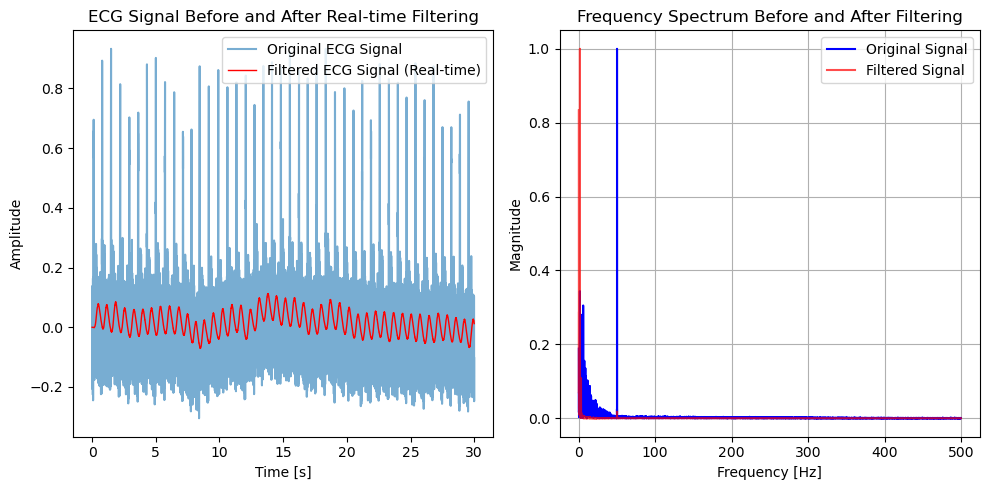

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load ECG signal data from file
path = 'ECG Traces-20241104/Noisy ECGs/Noisy_ECG_1000Hz_8.dat'
sampling_rate = 1000

def load_ecg_signal(filename, sampling_rate):
    try:
        ecg_signal = np.loadtxt(filename)
        return ecg_signal
    except ValueError:
        print('Error: Could not load file as text')
        return None
    
ecg_signal = load_ecg_signal(path, sampling_rate)

# Define a class for a real-time FIR filter
class FIRfilter:
    def __init__(self, coefficients):
        self.coefficients = coefficients
        self.buffer = np.zeros(len(coefficients))

    def dofilter(self, value):
        self.buffer = np.roll(self.buffer, -1)
        self.buffer[-1] = value
        result = np.dot(self.coefficients, self.buffer)
        return result


# Create FIR filter coefficients
fir_coeffs = combined_highpass_bandstop_fir(sampling_rate)
FIR_filter = FIRfilter(fir_coeffs)
# filtering the ECG signal
filtered_ecg_signal = np.array([FIR_filter.dofilter(n) for n in ecg_signal])
# calculate the time axis
duration = len(ecg_signal) / sampling_rate
time = np.linspace(0, duration, len(ecg_signal))

# Plot the original and filtered signals
fig = plt.figure(figsize=(10, 5))

# Plot the original and filtered signals in the time domain
fig1 = fig.add_subplot(1, 2, 1)
fig1.plot(time, ecg_signal, label='Original ECG Signal', alpha=0.6)
fig1.plot(time, filtered_ecg_signal, label='Filtered ECG Signal (Real-time)', color='red', linewidth=1)
fig1.legend()
fig1.set_title('ECG Signal Before and After Real-time Filtering')
fig1.set_xlabel('Time [s]')
fig1.set_ylabel('Amplitude')

# Calculate and plot the frequency spectrum of the original and filtered signals
def do_fft(signal, sampling_rate):
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), 1/sampling_rate)
    positive_freqs = freqs[:len(signal) // 2]
    positive_fft = fft_result[:len(signal) // 2]
    return positive_freqs, positive_fft

noise_freqs, noise_fft = do_fft(ecg_signal, sampling_rate)
filtered_freqs, filtered_fft = do_fft(filtered_ecg_signal, sampling_rate)

normalized_noise_fft = np.abs(noise_fft) / np.max(np.abs(noise_fft))
normalized_filtered_fft = np.abs(filtered_fft) / np.max(np.abs(filtered_fft))

# Plot the frequency spectrum of the original and filtered signals
fig2 = fig.add_subplot(1, 2, 2)
fig2.plot(noise_freqs, normalized_noise_fft, color = 'b',  label='Original Signal')
fig2.plot(filtered_freqs, normalized_filtered_fft, color = 'r',alpha=0.7, label='Filtered Signal')
fig2.set_title('Frequency Spectrum Before and After Filtering')
fig2.set_xlabel('Frequency [Hz]')
fig2.set_ylabel('Magnitude')
fig2.legend()
fig2.grid()

plt.tight_layout()
plt.show()

## Task 3
Use an adaptive LMS filter to filter out DC and 50Hz by providing it with a 50Hz sine wave with DC as reference.
* Note that both the amplitudes for the 50Hz and DC references scale with the learning rate. 
* Make appropriate choices for the **amplitudes** and the **learning rate** so that both DC and 50Hz are removed. 
* Add an adaptive LMS filter method to your FIR filter class (from 2.) and name it: “doFilterAdaptive(self,signal,noise,learningRate)” which returns the cleaned up ECG. 
* As before also this function must receive only scalars (i.e. sample by sample) and return a scalar. Plot and compare the result from the adaptive filter and that from the FIR filter design.

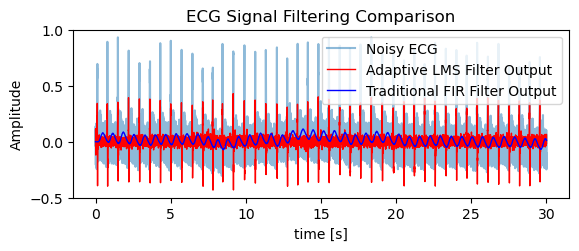

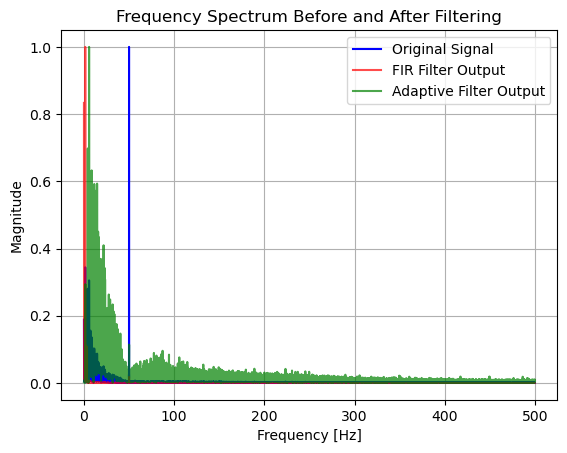

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate 50Hz reference signal with DC
def generate_reference_signals(sample_index, sampling_rate):
    dc_component = 1.0  # Constant for DC reference
    sin_50hz = np.sin(2 * np.pi * 50 * sample_index / sampling_rate)
    return dc_component, sin_50hz

# Define a class for adaptive FIR filter
class FIRFilter:
    def __init__(self, coefficients):
        self.coefficients = coefficients
        self.weights = np.zeros(2)

    def doFilterAdaptive(self, signal, referance_signal, learningRate):
              
        # set the reference signal
        dc_reference, sine_50hz = referance_signal 
        reference = np.array([dc_reference, sine_50hz])
        
        # Update the adaptive filter weights
        adaptive = np.dot(self.weights, reference)
        error = signal - adaptive
        
        # Update weights using LMS rule: w = w + 2 * learningRate * error * reference
        self.weights += 2 * learningRate * error * reference
        
        return error

# Load ECG signal data from file
def load_ecg_signal(filename, sampling_rate):
    try:
        ecg_signal = np.loadtxt(filename)
        return ecg_signal
    except ValueError:
        print('Error: Could not load file as text')
        return None

# set parameters
path = 'ECG Traces-20241104/Noisy ECGs/Noisy_ECG_1000Hz_8.dat'
sampling_rate = 1000
learning_rate = 0.05
n_taps = 20
duration = len(ecg_signal) / sampling_rate
time = np.linspace(0, duration, len(ecg_signal))

# Load the ECG signal
ecg_signal = load_ecg_signal(path, sampling_rate)
fir_filter = FIRFilter(coefficients=np.ones(n_taps) / n_taps)   # Initialize FIR filter
adaptive = [] # initialize the adaptive output

# Iterate over each sample in the ECG signal
for n, sample in enumerate(ecg_signal):
    dc_ref, sine_50hz_ref = generate_reference_signals(n, sampling_rate)
    filtered_adaptive = fir_filter.doFilterAdaptive(sample, (dc_ref, sine_50hz_ref), learning_rate)
    adaptive.append(filtered_adaptive)
    

# Convert to numpy arrays for plotting
adaptive_output = np.array(adaptive)

# Plot the original noisy ECG, adaptive filter output, and FIR filter output
fig = plt.figure()

# Plot in the time domain
fig1 = fig.add_subplot(2, 1, 1)
fig1.plot(time, ecg_signal, label='Noisy ECG', alpha=0.5)
fig1.plot(time, adaptive_output, label='Adaptive LMS Filter Output', color='red', linewidth=1)
plt.plot(time, filtered_ecg_signal, label='Traditional FIR Filter Output', color='blue', linewidth=1)
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Amplitude')
plt.title('ECG Signal Filtering Comparison')
plt.show()

# Calculate and plot the frequency spectrum
def do_fft(signal, sampling_rate):
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), 1/sampling_rate)
    positive_freqs = freqs[:len(signal) // 2]
    positive_fft = fft_result[:len(signal) // 2]
    return positive_freqs, positive_fft

adaptive_freqs, adaptive_fft = do_fft(adaptive_output, sampling_rate)
filtered_freqs, filtered_fft = do_fft(filtered_ecg_signal, sampling_rate)
original_freqs, original_fft = do_fft(ecg_signal, sampling_rate)

normalized_adaptive_fft = np.abs(adaptive_fft) / np.max(np.abs(adaptive_fft))
normalized_filtered_fft = np.abs(filtered_fft) / np.max(np.abs(filtered_fft))
normalized_original_fft = np.abs(original_fft) / np.max(np.abs(original_fft))

# plot the frequency spectrum
plt.figure()
plt.plot(original_freqs, normalized_original_fft, color = 'b',  label='Original Signal')
plt.plot(filtered_freqs, normalized_filtered_fft, color = 'r',alpha=0.7, label='FIR Filter Output')
plt.plot(adaptive_freqs, normalized_adaptive_fft, color = 'g',alpha=0.7, label='Adaptive Filter Output')
plt.title('Frequency Spectrum Before and After Filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.legend()
plt.grid()
plt.show()


## Task 4
ECG heartbeat detection: The task is to detect R-peaks in the noisy ECG recording. Use the FIR filter from 2. as a matched filter and use an R-peak as a template from the noise-free ECG. Plot the momentary heart rate (i.e. inverse intervals between R-peaks) against time. 

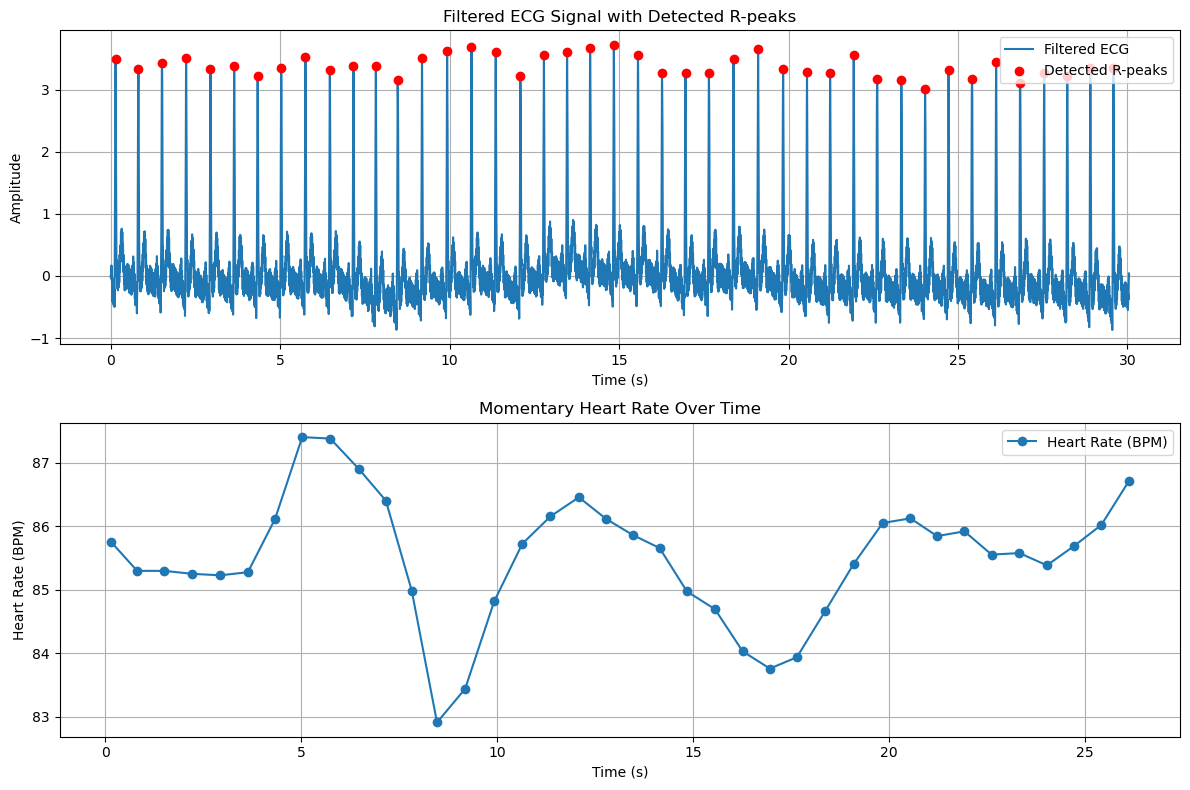

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Load ECG signal data from file
def load_ecg_signal(filename, sampling_rate):
    try:
        ecg_signal = np.loadtxt(filename)
        return ecg_signal
    except ValueError:
        print('Error: Could not load file as text')
        return None

# Define a function  to convolve
def my_convolve(signal, kernel):
    #  signal * kernel = intergral(signal(t) * kernel(t - tau) dtau)
    kernel = np.flip(kernel)
    output_len = len(signal) + len(kernel) - 1
    
    output = np.zeros(output_len) # Initialize the output array
    padded_signal = np.pad(signal, (len(kernel) - 1, len(kernel) - 1), mode='constant') # Pad the signal
    
    # Perform the convolution
    for i in range(output_len):
        output[i] = np.sum(padded_signal[i:i+len(kernel)] * kernel)
    
    return output

# Define a function to detect peaks
def detect_peaks(signal, min_distance, window_size):
    peaks = []
    for i in range(0, len(signal), window_size):
        local_signal = signal[i:i + window_size]
        local_threshold = np.mean(local_signal) + 2 * np.std(local_signal)
        for j in range(1, len(local_signal) - 1):
            if local_signal[j] > local_threshold and local_signal[j] > local_signal[j - 1] and local_signal[j] > local_signal[j + 1]:
                if len(peaks) == 0 or (i + j - peaks[-1]) > min_distance:
                    peaks.append(i + j)
    return np.array(peaks)

# Define a function to perform manual convolution
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

if __name__ == "__main__":
    # Load ECG signals
    fs = 1000
    clean_ecg = load_ecg_signal('ECG Traces-20241104/Lying ECGs/Lying_ECG_1000Hz_8.dat', fs)
    noisy_ecg = load_ecg_signal('ECG Traces-20241104/Noisy ECGs/Noisy_ECG_1000Hz_8.dat', fs)

    clean_threshold = np.mean(clean_ecg) + 2 * np.std(clean_ecg)
    clean_peaks = detect_peaks(clean_ecg, min_distance=int(fs * 0.6), window_size=fs // 2)
    start_idx = clean_peaks[0] - 25 # 25 samples before the first peak
    end_idx = clean_peaks[0] + 25
    r_peak_template = clean_ecg[start_idx:end_idx]

    # Perform manual convolution
    filtered_ecg = my_convolve(noisy_ecg, r_peak_template)

    # detect the R-pe
    threshold = np.mean(filtered_ecg) + 2 * np.std(filtered_ecg)
    r_peaks = detect_peaks(filtered_ecg, min_distance=int(fs * 0.6), window_size=fs // 2)

    # calculate the heart rate
    r_intervals = np.diff(r_peaks) / fs  
    heart_rate = 60 / r_intervals  
    time_points = r_peaks[:-1] / fs

    # soothe the heart rate
    heart_rate_smooth = moving_average(heart_rate, window_size=5)

    
    plt.figure(figsize=(12, 8))

    # Plot the filtered ECG signal with detected R-peaks
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(filtered_ecg)) / fs, filtered_ecg, label="Filtered ECG")
    plt.scatter(r_peaks / fs, filtered_ecg[r_peaks], color='red', label="Detected R-peaks", zorder=5)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Filtered ECG Signal with Detected R-peaks")
    plt.legend()
    plt.grid(True)

    #  Plot the heart rate over time
    plt.subplot(2, 1, 2)
    plt.plot(time_points[:len(heart_rate_smooth)], heart_rate_smooth, label="Heart Rate (BPM)", marker="o")
    plt.xlabel("Time (s)")
    plt.ylabel("Heart Rate (BPM)")
    plt.title("Momentary Heart Rate Over Time")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()